In [91]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer


import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("Data/re_dataset.csv",encoding="latin-1")
data.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [3]:
data.shape

(13169, 13)

## Data Analysis

### Perbandingan jumlah tiap label

In [4]:
label_size0 = []
label_size1 = []

for i in data.columns[1:]:
    label_size0.append(data.groupby(i).size().iloc[0])
    label_size1.append(data.groupby(i).size().iloc[1])

In [5]:
dat_anls = pd.DataFrame({
    'label' : data.columns[1:],
    'negative' : label_size0,
    'positive' : label_size1
})

dat_anls = dat_anls.set_index(['label'], drop=True)

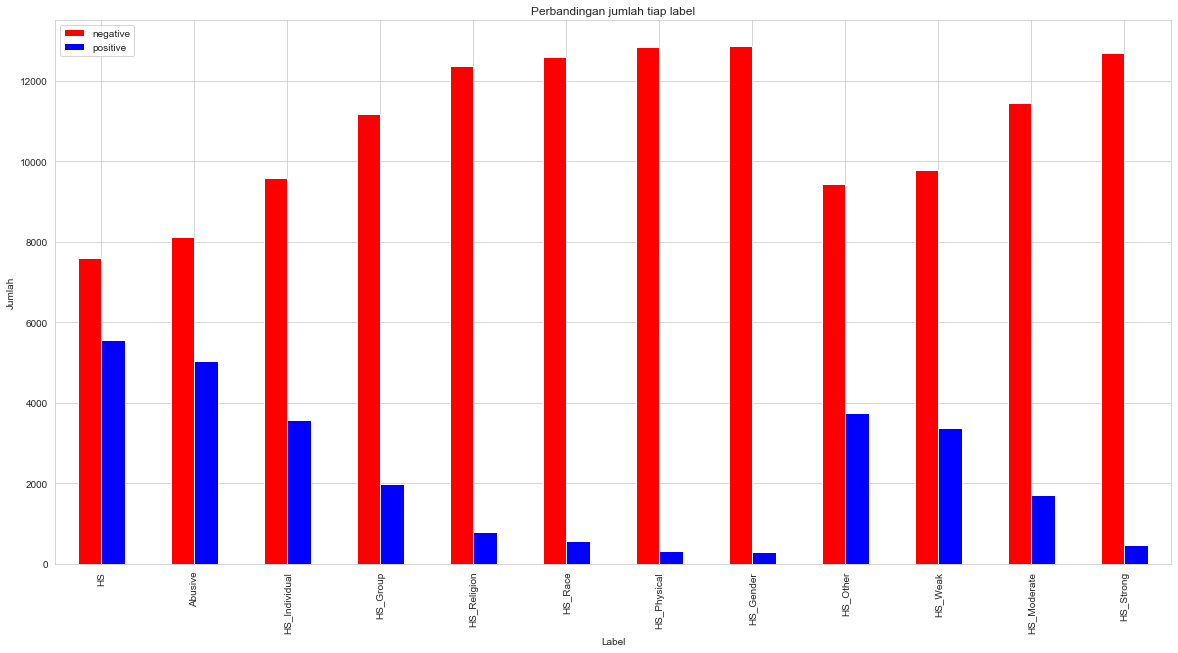

In [6]:
dat_anls.loc[:,['negative','positive']].plot.bar(color=['red','blue'], figsize=(20,10))
plt.title("Perbandingan jumlah tiap label")
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.show()

### Multiple labels per tweet

Text(0.5, 0, '# of labels')

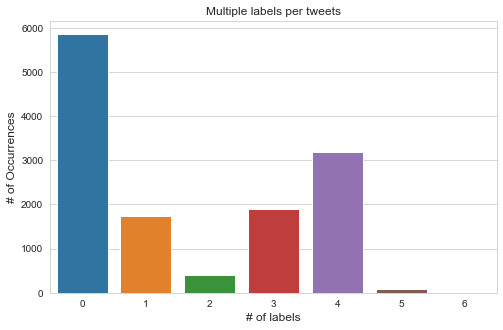

In [7]:
rowsums = data.iloc[:,2:-1].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple labels per tweets")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of labels', fontsize=12)

### Distribusi Panjang Karakter Tweet

In [76]:
data_anl = data[["Tweet"]].copy()

In [77]:
data_anl['Tweet_length'] = data_anl['Tweet'].str.len()

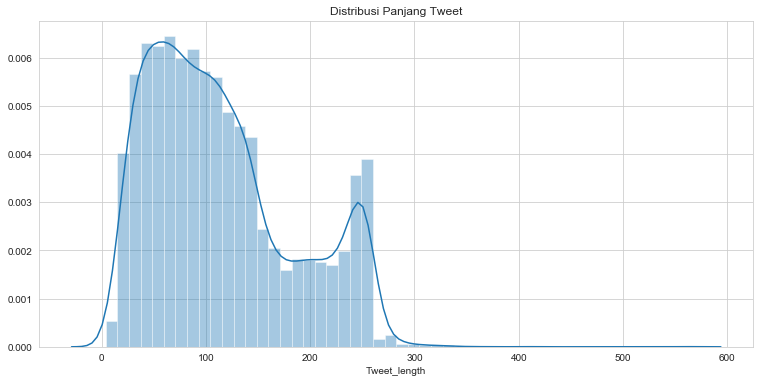

In [78]:
plt.figure(figsize=(12.8,6))
sns.distplot(data_anl['Tweet_length']).set_title('Distribusi Panjang Tweet');

In [81]:
data_anl['Tweet_length'].describe()

count    13169.000000
mean       114.074873
std         68.964345
min          4.000000
25%         59.000000
50%        100.000000
75%        152.000000
max        561.000000
Name: Tweet_length, dtype: float64

### Distribusi Panjang Kata Tweet

In [82]:
data_anl['word_count'] = data_anl['Tweet'].apply(lambda x: len(str(x).split()))

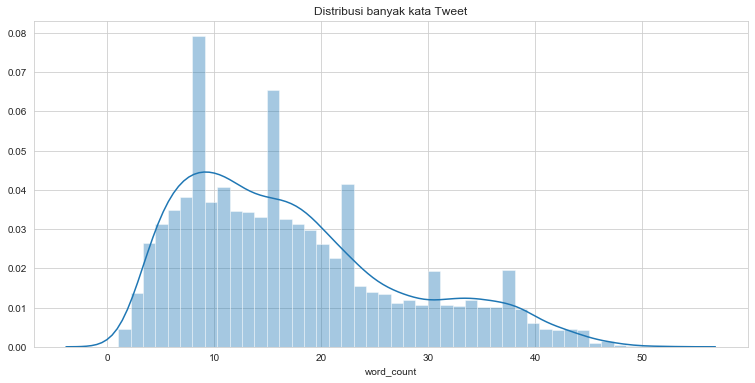

In [87]:
plt.figure(figsize=(12.8,6))
sns.distplot(data_anl['word_count']).set_title('Distribusi banyak kata Tweet');

In [88]:
data_anl['word_count'].describe()

count    13169.000000
mean        17.282102
std         10.231973
min          1.000000
25%          9.000000
50%         15.000000
75%         23.000000
max         52.000000
Name: word_count, dtype: float64

### Sampel Tweet

In [53]:
data['Tweet'].iloc[0]

"- disaat semua cowok berusaha melacak perhatian gue. loe lantas remehkan perhatian yg gue kasih khusus ke elo. basic elo cowok bego ! ! !'"

### Top 20 Words

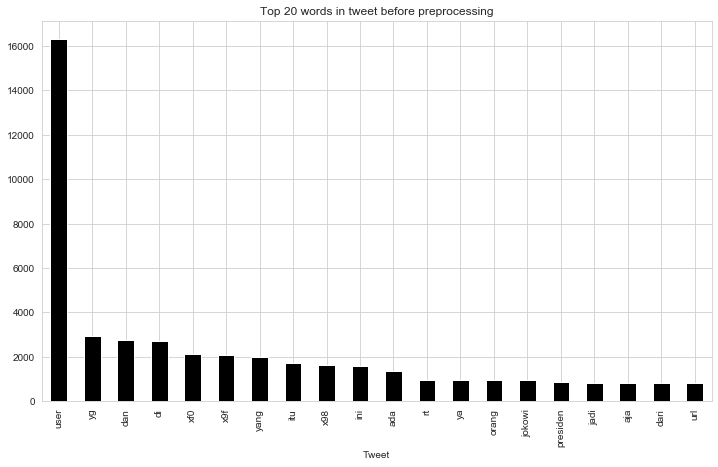

In [98]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(data_anl['Tweet'], 20)
# for word, freq in common_words:
#     print(word, freq)
topWord = pd.DataFrame(common_words, columns = ['Tweet' , 'count'])
topWord.groupby('Tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', y='Count', color='black', title='Top 20 words in tweet before preprocessing', figsize=(12,7))


### Top 20 Bigram

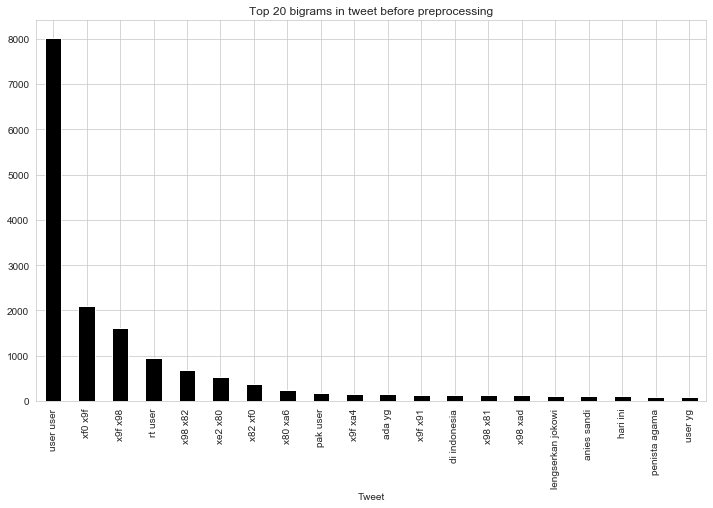

In [99]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(data_anl['Tweet'], 20)
# for word, freq in common_words:
#     print(word, freq)
topbigram = pd.DataFrame(common_words, columns = ['Tweet' , 'count'])
topbigram.groupby('Tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', y='Count', color='black', title='Top 20 bigrams in tweet before preprocessing', figsize=(12,7))


## Data Preprocessing

### Text Cleaning and Preparation

1. menghilangkan simbol khusus seperti \r, \n, "

In [11]:
data['Tweet_Parsed_1'] = data['Tweet'].str.replace("\r", " ")
data['Tweet_Parsed_1'] = data['Tweet_Parsed_1'].str.replace("\n", " ")
data['Tweet_Parsed_1'] = data['Tweet_Parsed_1'].str.replace("    ", " ")

In [12]:
data['Tweet_Parsed_1'] = data['Tweet_Parsed_1'].str.replace('"', '')

2. mengubah menjadi lower case

In [13]:
data['Tweet_Parsed_2'] = data['Tweet_Parsed_1'].str.lower()

3. Hapus simbol dan tanda baca

In [14]:
punctuation_signs = list("?:!.,;@#$%^&*()-+=_{}[]\|/><~`1234567890")
data['Tweet_Parsed_3'] = data['Tweet_Parsed_2']

for punct_sign in punctuation_signs:
    data['Tweet_Parsed_3'] = data['Tweet_Parsed_3'].str.replace(punct_sign, ' ')

4. Normalisasi Kata

In [15]:
kamus_normal = pd.read_csv("Data/new_kamusalay.csv",encoding='latin-1',header=None,names=["non-standard word","standard word"])
kamus_normal.head()

,non-standard word,standard word
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali


In [16]:
nonstdword = kamus_normal['non-standard word'].values.tolist()
stdword = kamus_normal['standard word'].values.tolist()

In [17]:
nonstdword

['anakjakartaasikasik',
 'pakcikdahtua',
 'pakcikmudalagi',
 't3tapjokowi',
 '3x',
 'aamiin',
 'aamiinn',
 'aamin',
 'aammiin',
 'abis',
 'abisin',
 'acau',
 'achok',
 'ad',
 'adek',
 'adl',
 'adlah',
 'adlh',
 'ado',
 'aduhh',
 'aer',
 'afdol',
 'agamaataualqur',
 'agm',
 'agma',
 'ahaha',
 'ahahaha',
 'ahehehehe',
 'ahir',
 'ahirnya',
 'ahk',
 'ahlamdulillah',
 'ahli2',
 'ahlusunnah',
 'ahmaddani',
 'aho',
 'ahoax',
 'ahoaxx',
 'ahog',
 'ahokataudjarot',
 'ahokbebanijokowi',
 'ahokbtp',
 'ahokditolakwarga',
 'ahokdjarot',
 'ahokdjarotterbukti',
 'ahokers',
 'ahokfighter',
 'ahokforpresident',
 'ahokisthebest',
 'ahokjarot',
 'ahokk',
 'ahokmasukbui',
 'ahokmeskipun',
 'ahokpositifjadi',
 'ahoksatuputaran',
 'ahoksemangat',
 'ahoktersangka',
 'ahokterzhalimi',
 'ahoktetap',
 'ahoktidaksendiri',
 'ahokUSER',
 'ahook',
 'ahox',
 'aing',
 'airmata',
 'aiskrim',
 'aj',
 'aja',
 'ajaa',
 'ajah',
 'ajalah',
 'aje',
 'ajg',
 'ajh',
 'ajib',
 'ajj',
 'ak',
 'akalakalan',
 'akalakaln',
 'akank

In [18]:
stdword

['anak jakarta asyik asyik',
 'pak cik sudah tua',
 'pak cik muda lagi',
 'tetap jokowi',
 'tiga kali',
 'amin',
 'amin',
 'amin',
 'amin',
 'habis',
 'habiskan',
 'kacau',
 'ahok',
 'ada',
 'adik',
 'adalah',
 'adalah',
 'adalah',
 'ada',
 'aduh',
 'air',
 'afdal',
 'agama alquran',
 'agama',
 'agama',
 'haha',
 'haha',
 'hehe',
 'akhir',
 'akhirnya',
 'ahok',
 'alhamdulillah',
 'para ahli',
 'ahlus sunah',
 'ahmad dhani',
 'ahok',
 'ahok',
 'ahok',
 'ahok',
 'ahok djarot',
 'ahok beban jokowi',
 'ahok basuki tjahaja purnama',
 'ahok ditolak warga',
 'ahok djarot',
 'ahok djarot terbukti',
 'ahoker',
 'ahok pejuang',
 'ahok for presiden',
 'ahok terbaik',
 'ahok djarot',
 'ahok',
 'ahok masuk bui',
 'ahok meskipun',
 'ahok positif jadi',
 'ahok satu putaran',
 'ahok semangat',
 'ahok tersangka',
 'ahok terzalimi',
 'ahok tetap',
 'ahok tidak sendiri',
 'ahok',
 'ahok',
 'ahok',
 'aku',
 'air mata',
 'es krim',
 'saja',
 'saja',
 'saja',
 'saja',
 'sajalah',
 'saja',
 'anjing',
 'saja'

In [19]:
def normalize_text(text, stdword_, nonstdword_):
    text = text.split(" ")
    for i in range(len(text)):
        if text[i] in nonstdword_:
            index = nonstdword_.index(text[i])
            text[i] = stdword_[index]
    return ' '.join(map(str, text))

In [20]:
data['Tweet_Parsed_4'] = data['Tweet_Parsed_3']

data['Tweet_Parsed_4'] = data['Tweet_Parsed_4'].map(lambda com : normalize_text(com,stdword,nonstdword))

5. Menghilangkan imbuhan (*stemming*)

In [21]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [22]:
def stemming(text, stemmer_):
    return stemmer.stem(text)

In [23]:
text = data['Tweet_Parsed_4'].values
stemmed_text = []

for i in text:
    text_split = i.split(" ")
    stemmed_list = []
    for j in text_split:
        stemmed_list.append(stemmer.stem(j))
    stemmed = ' '.join(map(str,stemmed_list))
    stemmed_text.append(stemmed)

data['Tweet_Parsed_5'] = stemmed_text

In [24]:
data['Tweet_Parsed_5'] = data['Tweet_Parsed_4']
data['Tweet_Parsed_5'] = data['Tweet_Parsed_4'].map(lambda com : stemming(com,stemmer))

6. Remove Stopword

In [25]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASLAB\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
stop_words = list(stopwords.words('indonesian'))

In [27]:
stop_words[1:10]

['adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir']

In [28]:
len(stop_words)

758

In [29]:
data['Tweet_Parsed_6'] = data['Tweet_Parsed_5']

for stop_word in stop_words:

    regex_stopword = r"\b" + stop_word + r"\b"
    data['Tweet_Parsed_6'] = data['Tweet_Parsed_6'].str.replace(regex_stopword, '')

7. clean space

In [39]:
def clean_space(text):
    text_split = text.split(' ')
    text_clean = [i for i in text_split if i != '']
    text_fix = ' '.join(map(str,text_clean))
    return text_fix

In [40]:
data['Tweet_Parsed_7'] = data['Tweet_Parsed_6']

data['Tweet_Parsed_7'] = data['Tweet_Parsed_7'].map(lambda com : clean_space(com))

### Preprocessing Result

In [134]:
idx_length150 = data_anl[data_anl['Tweet_length']==90].index.values[0]

In [135]:
data['Tweet'].loc[idx_length150]

'Mari kita wujudkan Pilkada Kota Bengkulu 2018 aman dan damai.; .; .; coki_adem86 98heruâ?¦'

In [136]:
data['Tweet_Parsed_1'].loc[idx_length150]

'Mari kita wujudkan Pilkada Kota Bengkulu 2018 aman dan damai.; .; .; coki_adem86 98heruâ?¦'

In [137]:
data['Tweet_Parsed_2'].loc[idx_length150]

'mari kita wujudkan pilkada kota bengkulu 2018 aman dan damai.; .; .; coki_adem86 98heruâ?¦'

In [138]:
data['Tweet_Parsed_3'].loc[idx_length150]

'mari kita wujudkan pilkada kota bengkulu      aman dan damai         coki adem     heruâ ¦'

In [139]:
data['Tweet_Parsed_4'].loc[idx_length150]

'mari kita wujudkan pilihan kepala daerah kota bengkulu      aman dan damai         coki adem     heruâ ¦'

In [140]:
data['Tweet_Parsed_5'].loc[idx_length150]

'mari kita wujud pilih kepala daerah kota bengkulu aman dan damai cok adem heru'

In [141]:
data['Tweet_Parsed_6'].loc[idx_length150]

'mari  wujud pilih kepala daerah kota bengkulu aman  damai cok adem heru'

In [142]:
data['Tweet_Parsed_7'].loc[idx_length150]

'mari wujud pilih kepala daerah kota bengkulu aman damai cok adem heru'

## Data Fix

In [42]:
data.columns

Index(['Tweet', 'HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion',
       'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak',
       'HS_Moderate', 'HS_Strong', 'Tweet_Parsed_1', 'Tweet_Parsed_2',
       'Tweet_Parsed_3', 'Tweet_Parsed_4', 'Tweet_Parsed_5', 'Tweet_Parsed_6',
       'Tweet_Parsed_7'],
      dtype='object')

In [43]:
data_fix = data.drop(['Tweet_Parsed_1', 'Tweet_Parsed_2','Tweet_Parsed_3','Tweet_Parsed_4','Tweet_Parsed_5','Tweet_Parsed_6'],axis=1)

data_fix = data_fix.rename(columns={'Tweet_Parsed_7': 'Tweet_Parsed'})

In [44]:
data_fix.head(10)

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0,cowok usaha lacak perhati gue lantas remeh per...
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0,rt telat tau edan sarap gue gaul cigax jifla c...
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0,kadang pikir percaya tuhan jatuh kali kali kad...
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0,ku tau mata sipit lihat
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0,kaum cebong kafir lihat dongok dungu hahahah
5,USER Ya bani taplak dkk \xf0\x9f\x98\x84\xf0\x...,1,1,0,1,0,0,0,0,1,0,1,0,ya bani taplak kawan kawan xf x f x x xf x f x...
6,deklarasi pilkada 2018 aman dan anti hoax warg...,0,0,0,0,0,0,0,0,0,0,0,0,deklarasi pilih kepala daerah aman anti hoaks ...
7,Gue baru aja kelar re-watch Aldnoah Zero!!! pa...,0,1,0,0,0,0,0,0,0,0,0,0,gue selesai re watch aldnoah zero kampret kara...
8,Nah admin belanja satu lagi port terbaik nak m...,0,0,0,0,0,0,0,0,0,0,0,0,admin belanja port nak makan ais kepal milo ai...
9,USER Enak lg klo smbil ngewe',0,1,0,0,0,0,0,0,0,0,0,0,enak ngewe


## Missing Values

In [47]:
pd.isnull(data_fix).sum()

Tweet            0
HS               0
Abusive          0
HS_Individual    0
HS_Group         0
HS_Religion      0
HS_Race          0
HS_Physical      0
HS_Gender        0
HS_Other         0
HS_Weak          0
HS_Moderate      0
HS_Strong        0
Tweet_Parsed     0
dtype: int64

In [49]:
data_fix.loc[data_fix['Tweet_Parsed'] == '', ['Tweet_Parsed']] = " "

## Analysis Data After Preprocessed

### Empty String

In [102]:
data_fix[data_fix['Tweet_Parsed'] == ' '].count()

Tweet            47
HS               47
Abusive          47
HS_Individual    47
HS_Group         47
HS_Religion      47
HS_Race          47
HS_Physical      47
HS_Gender        47
HS_Other         47
HS_Weak          47
HS_Moderate      47
HS_Strong        47
Tweet_Parsed     47
dtype: int64

### Distribusi Panjang Karakter Tweet

In [103]:
data_anl_ = data_fix[["Tweet_Parsed"]].copy()

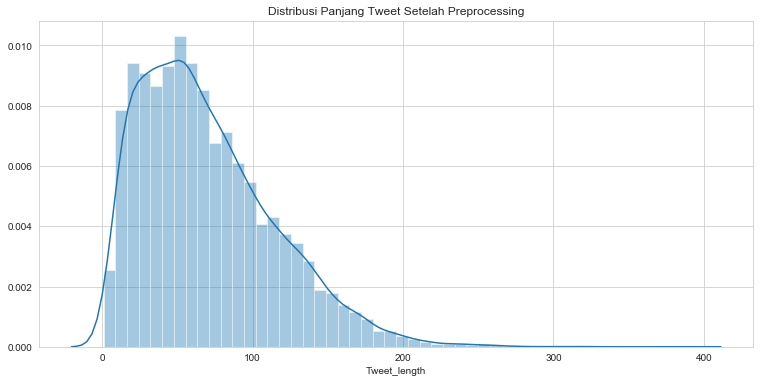

In [104]:
data_anl_['Tweet_length'] = data_anl_['Tweet_Parsed'].str.len()
plt.figure(figsize=(12.8,6))
sns.distplot(data_anl_['Tweet_length']).set_title('Distribusi Panjang Tweet Setelah Preprocessing');

In [105]:
data_anl_['Tweet_length'].describe()

count    13169.000000
mean        69.817754
std         44.782009
min          1.000000
25%         35.000000
50%         61.000000
75%         96.000000
max        390.000000
Name: Tweet_length, dtype: float64

### Distribusi Banyak Kata Per Tweet

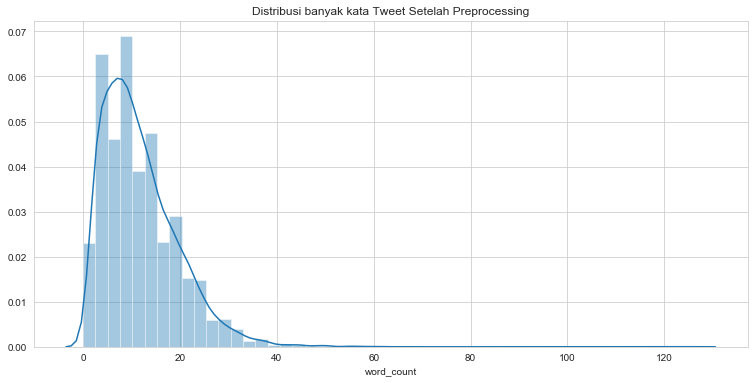

In [106]:
data_anl_['word_count'] = data_anl_['Tweet_Parsed'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(12.8,6))
sns.distplot(data_anl_['word_count']).set_title('Distribusi banyak kata Tweet Setelah Preprocessing');

In [107]:
data_anl_['word_count'].describe()

count    13169.000000
mean        11.743868
std          7.747923
min          0.000000
25%          6.000000
50%         10.000000
75%         16.000000
max        127.000000
Name: word_count, dtype: float64

### Top 20 Word After Preprocessing

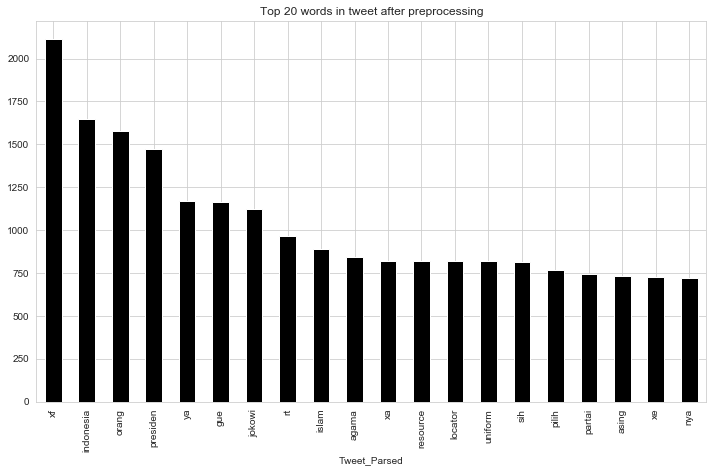

In [108]:
common_words_ = get_top_n_words(data_anl_['Tweet_Parsed'], 20)
# for word, freq in common_words:
#     print(word, freq)
topWord_ = pd.DataFrame(common_words_, columns = ['Tweet_Parsed' , 'count'])
topWord_.groupby('Tweet_Parsed').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', y='Count', color='black', title='Top 20 words in tweet after preprocessing', figsize=(12,7))

### Top 20 Bigram After Preprocessing

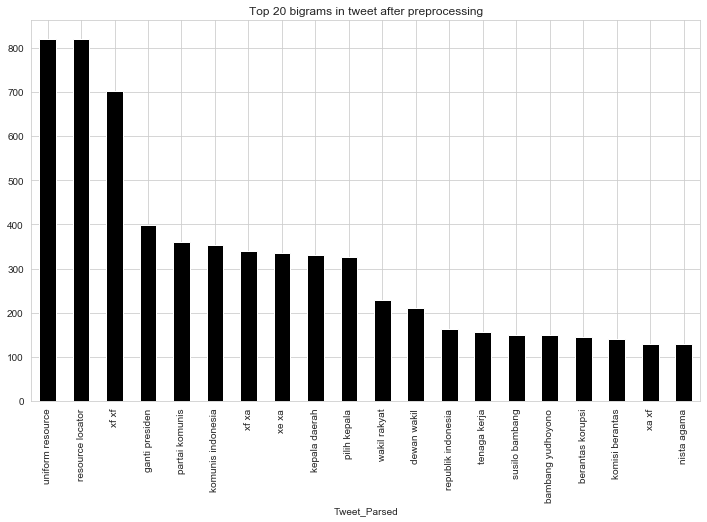

In [109]:
common_words_ = get_top_n_bigram(data_anl_['Tweet_Parsed'], 20)
# for word, freq in common_words:
#     print(word, freq)
topbigram_ = pd.DataFrame(common_words_, columns = ['Tweet_Parsed' , 'count'])
topbigram_.groupby('Tweet_Parsed').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', y='Count', color='black', title='Top 20 bigrams in tweet after preprocessing', figsize=(12,7))

## Save Preprocessed Data

In [50]:
data_fix.to_csv('Data/Preprocessed_Data.csv', index = False)